<a href="https://colab.research.google.com/github/hannaribaspeeters/NLP-ETH/blob/main/context_free_parsing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

In this practical part of the assignment, you will implement a model that takes a sentence as input and predicts the most likely CFG parse tree given that sentence:
$$
\mathbf{t} = \text{argmax}_\mathbf{t}P(\mathbf{t}|\mathbf{s})
$$


You will do this by converting the words into embeddings, and then implementing the CKY algorithm on top of an LSTM which you will train end-to-end.

## Dependencies
Please run the following cell to install the necessary dependencies for this notebook.

In [ ]:
!pip install dynet
!pip install svgling

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 39.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.1/67.1 KB 5.6 MB/s eta 0:00:00


Also, please add [this folder](https://drive.google.com/drive/folders/1FgT2bQdH0eCDDaqkDGk7hORUUDGd6a9t?usp=sharing) to your google drive, and then run the following cell:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/MyDrive/nlp-h2022-parsing'

Mounted at /content/drive
/content/drive/MyDrive/nlp-h2022-parsing


# 1. Training Data

In this section, you will download, interact with, and clean the data which you will use to train and test your model. We will be using the Penn Treebank, an corpus of sentences annotated with Part of Speech tags and CFG parse trees. For ease of computation under limited resources, we will be using a fraction (10%) of the treebank corpus which is distributed with the **nltk** python library.

## The Raw Data
Download the data by executing the following code:

In [ ]:
import nltk
from nltk.corpus import LazyCorpusLoader, BracketParseCorpusReader
nltk.download('treebank')
treebank = LazyCorpusLoader('treebank/combined', BracketParseCorpusReader, r'wsj_.*\.mrg')

[nltk_data] Downloading package treebank to /root/nltk_data...
[nltk_data]   Unzipping corpora/treebank.zip.


Have a look at the first few examples:

In [ ]:
treebank.parsed_sents()[1:3]

[Tree('S', [Tree('NP-SBJ', [Tree('NNP', ['Mr.']), Tree('NNP', ['Vinken'])]), Tree('VP', [Tree('VBZ', ['is']), Tree('NP-PRD', [Tree('NP', [Tree('NN', ['chairman'])]), Tree('PP', [Tree('IN', ['of']), Tree('NP', [Tree('NP', [Tree('NNP', ['Elsevier']), Tree('NNP', ['N.V.'])]), Tree(',', [',']), Tree('NP', [Tree('DT', ['the']), Tree('NNP', ['Dutch']), Tree('VBG', ['publishing']), Tree('NN', ['group'])])])])])]), Tree('.', ['.'])]),
 Tree('S', [Tree('NP-SBJ-1', [Tree('NP', [Tree('NNP', ['Rudolph']), Tree('NNP', ['Agnew'])]), Tree(',', [',']), Tree('UCP', [Tree('ADJP', [Tree('NP', [Tree('CD', ['55']), Tree('NNS', ['years'])]), Tree('JJ', ['old'])]), Tree('CC', ['and']), Tree('NP', [Tree('NP', [Tree('JJ', ['former']), Tree('NN', ['chairman'])]), Tree('PP', [Tree('IN', ['of']), Tree('NP', [Tree('NNP', ['Consolidated']), Tree('NNP', ['Gold']), Tree('NNP', ['Fields']), Tree('NNP', ['PLC'])])])])]), Tree(',', [','])]), Tree('VP', [Tree('VBD', ['was']), Tree('VP', [Tree('VBN', ['named']), Tree('S',

The parenthes encode a tree structure which can be pretty printed by calling a single example:

## Cleaning the data

Next, we will prepare the data so it can be used to train our parser. For this part, please make yourself familiar with the [nltk.tree](https://www.nltk.org/_modules/nltk/tree.html) module.

Look at the following subtree.

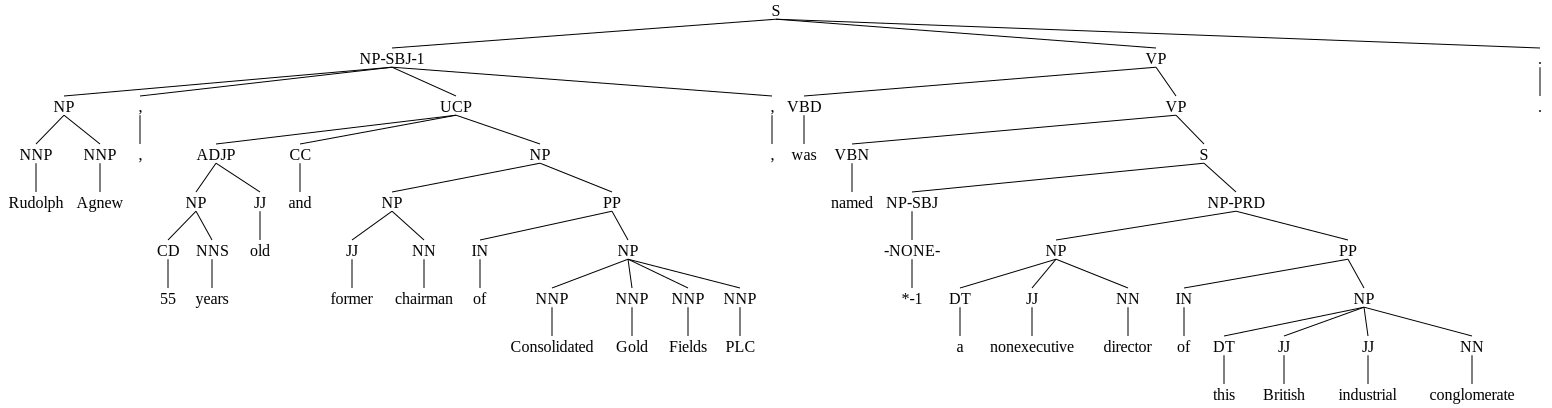

In [ ]:
treebank.parsed_sents()[2]

First, note that nonterminals can have a variable number of children. However, in order for CKY to work, we require the data to be in Chomsky Normal Form (CNF), i.e. it needs to be binarized.
We also want to simplify tags that have hyphens in them, and filter out -NONE- tags (which are used e.g. to indicate relative clauses).



### 1.1 Removing -NONE-, -RCB-, and -LRB- tags
We want to remove `-NONE-`, `-LRB-` and `-RCB-` tags. For the sake of simplicity, we will remove any tree that contains these tags. Write a method that returns True if a tree passed to it contains such tags. In a comment (without implementing the code), give two other ways `-NONE-` tags could be handled more data efficiently without affecting the grammaticality of the sentence.


*Find them and eliminate it*

In [ ]:
from nltk import Tree

bad_tags = ['-NONE-', '-LRB-', '-RCB-']

def contains_none_tags(tree):
    """
    parameters:
        tree: parse tree

    returns:
        True iff the tree contains NONE, LRB or RCB tags.
    """
    boolean = False

    for pos in tree.treepositions():
        # non-terminal symbols
        if (type(tree[pos])!=str):
            if tree[pos].label() in bad_tags:
                boolean = True
    return boolean

contains_none_tags(treebank.parsed_sents()[5][0]) # this should return True

True

### 1.2 Simplifying Functional Tags
Write a method that takes in tags and only keeps the part before the first hyphen if it is hyphenated - e.g. `NP-SBJ` should become `NP`. Then write a method that traverses a tree and updates its tags in place.


*We want to make the tag vocabulary smaller to make it fasteR*

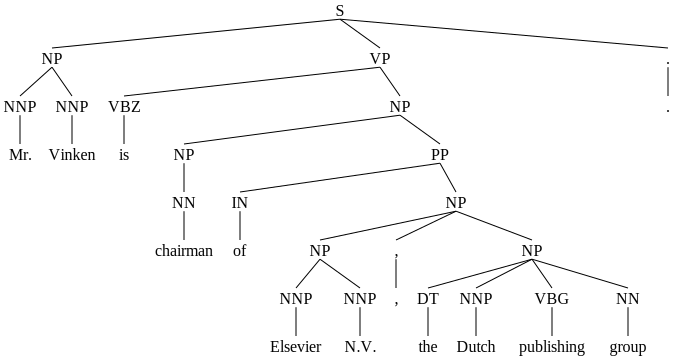

In [ ]:
def simplify_functional_tag(tag):
    """
    parameters:
        tag: string

    returns:
        the tag up to the first hyphen

    """
    if tag in bad_tags:
        return tag

    else:
        return tag.split('-')[0]

def simplify_tags(tree):
    """
    Traverses a parse tree and simplifies tags containing hyphens

    parameters:
        tree: parse tree

    returns:
        parse tree with simplified tags (up to the first hyphen)
    """
    for pos in tree.treepositions():
        # non-terminal symbols
        if (type(tree[pos])!=str):
            tree[pos].set_label(simplify_functional_tag(tree[pos].label()))

simplified_tree = treebank.parsed_sents()[1].copy(deep=True)
simplify_tags(simplified_tree)
simplified_tree

### 1.3 Binarizing the Parse Trees
To remove unary derivations and convert the training trees to binary trees, we will use the functions `collapse_unary` and `chomsky_normal_form` in [nltk.tree](https://www.nltk.org/_modules/nltk/tree.html). Write down the call you will make using horizontal markov smoothing of 1 and vertical markov smoothing of 0, factoring right, and using ^ for parent and | for child. **Explain the meaning and the purpose of these parameters in a comment**.

*We need to binarize the parse trees: every node inside the tree has two children and the terminal node has exactly one child*

In [ ]:
from nltk.tree import collapse_unary, chomsky_normal_form

def binarize(tree):
    """
    Collapses unary productions and binarizes a parse tree in place.

    parameters:
        tree: parse tree

    returns:
        None
    """

    collapse_unary(tree)
    chomsky_normal_form(tree,
                        factor="right",
                        horzMarkov=1,
                        vertMarkov=0,
                        childChar="|",
                        parentChar="^")


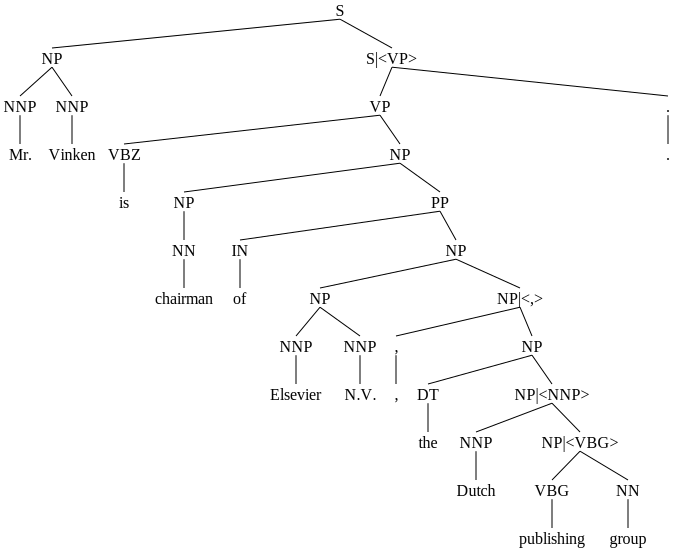

In [ ]:
binarized_tree = simplified_tree.copy(deep=True)
binarize(binarized_tree)
binarized_tree

*every word in a sentence is a tuple of the word and annotation*

### 1.4 Run Data Preprocessing

Bringing all of these together, write a method that takes a set of trees and returns a list of (copied) cleaned trees:

In [ ]:
def clean_trees(trees):
    """
    Cleans parse trees from the penn treebank by performing tag simplification,
        binarization, and filtering out trees with NONE tags.

    parameters:
        trees: parse trees

    returns:
        list of cleaned trees
    """
    clean_trees = []

    for t in trees:
        tree = t.copy(deep=True)
        simplify_tags(tree)
        binarize(tree)
        if not contains_none_tags(tree):
            clean_trees.append(tree)

    return clean_trees

trees_cleaned = clean_trees(treebank.parsed_sents())

Now we can write the cleaned data to the disk to use as training and test data later (using an 80:20 split).

In [ ]:
def flatten(tree):
    return tree._pformat_flat("", "()", False)

# 90-10 % split
trees_train = trees_cleaned[:886]
trees_test = trees_cleaned[886:]

with open("data/train.clean", "w") as f:
    for tree in trees_train:
        flat_tree = flatten(tree)
        f.write(f"{flat_tree}\n")

with open("data/test.clean", "w") as f:
    for tree in trees_test:
        flat_tree = flatten(tree)
        f.write(f"{flat_tree}\n")

# 2. Neural Constituency Parser

Now we want to train our model to parse from scratch, by providing it with training examples and optimizing it.
We will use a bidirectional LSTM.

## Defining the vocabulary
First, load the training and test data we created in part 1.

In [ ]:
from src import trees

train_path = "data/train.clean"
test_path = "data/test.clean"

train_treebank = trees.load_trees(train_path)
test_treebank = trees.load_trees(test_path)

print(f"Loaded {len(train_treebank)} training examples.")
print(f"Loaded {len(test_treebank)} test examples.")

print("Processing trees for training...")
train_parse = [tree.convert() for tree in train_treebank]

Loaded 886 training examples.
Loaded 100 test examples.
Processing trees for training...


In [ ]:
train_parse[0]

Then, we collect the vocabulary for words, tags, and labels from the training data, creating a reverse index to look up the index of words in our vocabulary.

In [ ]:
from src import vocabulary

START = "<START>"
STOP = "<STOP>"
UNK = "<UNK>"

tag_vocab = vocabulary.Vocabulary()
tag_vocab.index(START)
tag_vocab.index(STOP)

word_vocab = vocabulary.Vocabulary()
word_vocab.index(START)
word_vocab.index(STOP)
word_vocab.index(UNK)

label_vocab = vocabulary.Vocabulary()
label_vocab.index(())

for tree in train_parse:
    nodes = [tree]
    while nodes:
        node = nodes.pop()
        if isinstance(node, trees.InternalParseNode):
            label_vocab.index(node.label)
            nodes.extend(reversed(node.children))
            print(node.label)
        else:
            tag_vocab.index(node.tag)
            word_vocab.index(node.word)

tag_vocab.freeze()
word_vocab.freeze()
label_vocab.freeze()

In [ ]:
label_vocab.values

In [ ]:
tag_vocab.values

['<START>',
 '<STOP>',
 'NNP',
 ',',
 'CD',
 'NNS',
 'JJ',
 'MD',
 'VB',
 'DT',
 'NN',
 'IN',
 '.',
 'VBZ',
 'VBG',
 'VBD',
 '``',
 'PRP',
 'VBP',
 'EX',
 'PRP$',
 'RB',
 "''",
 'CC',
 'VBN',
 'POS',
 'TO',
 'JJS',
 'JJR',
 ':',
 'RP',
 'RBR',
 'NNPS',
 'WRB',
 'RBS',
 'PDT',
 'LS',
 'FW',
 'WP',
 '$']

In [ ]:
word_vocab.values

## Defining the model
Now, we will define the neural network model that will predict label scores for spans. The reference implementation uses a bidirectional LSTM which you can define using dynet's [BiRNNBuilder class](https://dynet.readthedocs.io/en/latest/python_ref.html#dynet.BiRNNBuilder).

In [ ]:
import dynet as dy
from src.util import Feedforward

dy.reset_random_seed(42)

# Create a dynet model
model = dy.ParameterCollection()
parser_model = model.add_subcollection("Parser")

batch_size = 10
tag_embedding_dim = 50
word_embedding_dim = 100
lstm_layers = 2
lstm_dim = 250
label_hidden_dim = 250
dropout = 0.4

tag_embeddings = parser_model.add_lookup_parameters((tag_vocab.size, tag_embedding_dim))
word_embeddings = parser_model.add_lookup_parameters((word_vocab.size, word_embedding_dim))

# Create a lstm using the dynet BiRNNBuilder
lstm = dy.BiRNNBuilder(
    lstm_layers,
    tag_embedding_dim + word_embedding_dim,
    2 * lstm_dim,
    parser_model,
    dy.VanillaLSTMBuilder)

# Define a Feedforward neural net that predicts the label probabilities given lstm outputs from a sentence
f_label = Feedforward(parser_model, 2 * lstm_dim, [label_hidden_dim], label_vocab.size - 1)

## 2.1 Generating Embeddings

Next we need to convert the words and tags into embeddings that can be fed to the LSTM. Implement the following method.
Unknown words should get the embedding of the UNK word.

Hint: use the reverse index methods `tag_vocab.index()` and `word_vocab.index()` methods from `vocabulary.py` to find the keys of words and tags in the respective embedding dicts created above.

In [ ]:
tag_vocab.values

['<START>',
 '<STOP>',
 'NNP',
 ',',
 'CD',
 'NNS',
 'JJ',
 'MD',
 'VB',
 'DT',
 'NN',
 'IN',
 '.',
 'VBZ',
 'VBG',
 'VBD',
 '``',
 'PRP',
 'VBP',
 'EX',
 'PRP$',
 'RB',
 "''",
 'CC',
 'VBN',
 'POS',
 'TO',
 'JJS',
 'JJR',
 ':',
 'RP',
 'RBR',
 'NNPS',
 'WRB',
 'RBS',
 'PDT',
 'LS',
 'FW',
 'WP',
 '$']

In [ ]:
def convert_to_embeddings(sentence):
    """
    Converts a sentence consisting of tags and words into embeddings.
        Replaces words not in the vocabulary with with the UNK placeholder.

    params:
        sentence: list of tuples of (tag, word)

    return:
        dy expression containing a concatenation of all tag embedding/word embedding pairs
    """
    embeddings = []
    for tag, word in [(START, START)] + sentence + [(STOP, STOP)]:

        ### YOUR CODE HERE
        if word not in word_vocab.values:
            word = UNK

        tag_embedding = tag_embeddings[tag_vocab.index(tag)]
        word_embedding = word_embeddings[word_vocab.index(word)]
        ### YOUR CODE END

        embeddings.append(dy.concatenate([tag_embedding, word_embedding]))
    return embeddings

To test your code, run the following cell on the sentence `The boy ate a pie` with tags ['DT', 'NN', 'VBZ' 'DT', 'NN']:

In [ ]:
sentence = [('DT', 'The'),('NN','boy'),('VBZ','ate'), ('DT', 'a'), ('NN', 'pie')]
embeddings = convert_to_embeddings(sentence)
assert len(embeddings)==7
assert len(embeddings[0].value())==150
assert embeddings[5].value() == dy.concatenate(
    [tag_embeddings[tag_vocab.index('NN')],
     word_embeddings[word_vocab.index(UNK)]]).value()

We can now use the above method to get the lstm outputs for the whole sentence:

In [ ]:
def get_lstm_outputs(sentence, is_train):
    """
    Gets the outputs of the lstm for a given sentence.

    parameters:
        sentence: list of tuples of (tag, word)

    returns:
        lstm_outputs

    """

    if is_train:
        lstm.set_dropout(dropout)
    else:
        lstm.disable_dropout()

    # Get the tag and word embeddings for the sentence
    embeddings = convert_to_embeddings(sentence)

    # Get the output of the LSTM given the embedded sentence
    lstm_outputs = lstm.transduce(embeddings)

    return lstm_outputs

The following two methods are helper methods which compute the scores for each label given a span.

In [ ]:
from src.util import augment

def get_span_encoding(left, right, lstm_outputs):
    """
    Computes the encoding of a sentence span (substring between two indices)
        given the forward and backward outputs in the LSTM.

    parameters:
        left: left span index
        right: right span index

    returns:
        encoding of the span
    """
    forward = (
        lstm_outputs[right][:lstm_dim] -
        lstm_outputs[left][:lstm_dim])
    backward = (
        lstm_outputs[left + 1][lstm_dim:] -
        lstm_outputs[right + 1][lstm_dim:])
    return dy.concatenate([forward, backward])

def get_label_scores(left, right, lstm_outputs, gold, force_gold):
    """
    Computes the best label for a given span and its score.

    parameters:
        left: left index of the span
        right: right index of the span
        lstm_outputs: outputs of the lstm when given the sentence
        gold reference parse tree for the sentence
        force_gold: True if method should construct the gold parse tree
          and compute its score

    returns:
        (label, score):
            label: the highest scoring label if force_gold is False,
              or the gold label if force_gold is true
            score: the score of the label
    """
    is_train = gold is not None

    label_scores = f_label(get_span_encoding(left, right, lstm_outputs))
    label_scores = dy.concatenate([dy.zeros(1), label_scores])

    if is_train:
        oracle_label = gold.oracle_label(left, right)
        oracle_label_index = label_vocab.index(oracle_label)

    if force_gold:
        label_score = label_scores[oracle_label_index]
        label = oracle_label

    else:
        if is_train:
            label_scores = augment(label_scores, oracle_label_index)
        label_scores_np = label_scores.npvalue()
        span = right - left
        argmax_label_index = int(
                        label_scores_np.argmax() if span < len(sentence) else
                        label_scores_np[1:].argmax() + 1)
        label = label_vocab.value(argmax_label_index)
        label_score = label_scores[argmax_label_index]
    return label, label_score

## 2.2 CKY with estimated label probabilites
Now we can implement the parser method. It works like CKY, with some additions.

During training, the `gold` parameter is set, representing the reference parse tree. During inference, this is not set and the method simply returns the best scoring parse tree.

Your task is to implement the CKY algorithm, iterating through spans and for each pair of span indices dynamically calculate scores and parse trees:
1. Use the method `get_label_scores(left, right, lstm_outputs, gold, force_gold)` to get the scores for each label corresponding to the given span (left, right).
2. Find the best place to split a given span into two subspans given their respective label scores. (If `force_gold` is set, use the method `tree.oracle_splits(left, right)` from `trees.py` to get the split positions, and use the first of them as the index to split the tree.)
3. Calculate the score of the label when splitting at the best index found above and put it into the scores `chart`.
4. Get the subtrees for the span and split position, and put the resulting new subtree into the `parse_trees` dict.

*Hint: the label scores are stored as dynet expressions, use `.value()` to get the score value.*

We estimate a score for each span, and, if that score is high enough, give it a label. This is all done through the get_label_scores method, so we only need to figure out how to compute the score by splitting the chart to maximise the score.


Hint for 2.b) ii): If you don't get a label for an entry in the parse_tree chart, just concatenate the lists of child trees and store that new list in the chart instead

Another thing for 2.b) ii): the gold_tree parameter tells the method that computes the label scores that it is currently training which changes how it computes the scores. So including that parameter for training will yield a better result in the end.

The sum of a single parse tree is the sum of span scores (Computed in CKY style). --> adding the highest sum of two sub-span scores plus the score of the span itself.

In [ ]:
from src import trees

def parse(sentence, gold=None, force_gold=False):
    """
    Generates the best scoring parse tree for a given sentence.

    parameters:
        sentence: list of tuples of (tag, word)
        gold: gold reference parse tree for the sentence
        force_gold: If true, method will construct the gold parse tree
            and compute its score, otherwise it will compute the
            best scoring parse tree.

    returns:
        (tree, score):
            tree: constructed best or gold parse tree
            score: score of the constructed parse tree
    """
    N = len(sentence)

    chart = {}
    parse_trees = {}

    is_train = gold is not None
    lstm_outputs = get_lstm_outputs(sentence, is_train)

    for i in range(N):
        tag, word = sentence[i]
        label, score = get_label_scores(i, i + 1, lstm_outputs, gold, force_gold)
        tree = trees.LeafParseNode(i, tag, word)
        if label:
            tree = trees.InternalParseNode(label, [tree])
        parse_trees[i, i + 1] = [tree]
        chart[i, i + 1] = score

    ### YOUR CODE HERE

    for span in range(2, N+1):
        # i marks the beginning of the span
        # k marks the end of the span
        # j marks the splitting point of the span

        for i in range(N-span+1):
            k = i + span
            # compute the score of the span and the label if the score is high enough
            label, score = get_label_scores(i, k, lstm_outputs, gold, force_gold)

            # if there is a gold_tree
            if force_gold:
                split = gold.oracle_splits(i, k)[0]

            else:
                # look for the split that gets the highest addition of subspan scores
                scores = []
                for j in range(i+1, k):
                    sub_score = chart[i, j] + chart[j, k]
                    scores.append(sub_score.value())

                split = i + scores.index(max(scores)) + 1

            subtree1 = parse_trees[i, split]
            subtree2 = parse_trees[split, k]

            if label:
                tree = [trees.InternalParseNode(label, subtree1 + subtree2)]
            else:
                tree = subtree1 + subtree2

            # adding the highest sum of two sub-span scores plus the score of the span itself
            chart[i, k] = chart[i, split] + chart[split, k] + score
            parse_trees[i, k] = tree

    ### YOUR CODE END

    assert len(parse_trees[0, N]) == 1
    tree = parse_trees[0, N][0]
    score = chart[0, N]
    return tree, score

In [ ]:
import numpy as np

sentence = [('DT', 'The'),('NN','boy'),('VBZ','ate'), ('DT', 'a'), ('NN', 'pie')]
tree, score =  parse(sentence)
score.value()


The dy.parameter(...) call is now DEPRECATED.
        There is no longer need to explicitly add parameters to the computation graph.
        Any used parameter will be added automatically.


1.4991785287857056

Test your code on the sentence from before. Don't worry if the parse tree does not make sense right now, since the model has not been trained yet. You should get the following tree and score:

`tree:  (S|<ADJP> (S|<ADJP> (S|<ADJP> (DT The)) (S|<ADJP> (S|<ADJP> (NN boy)) (S|<ADJP> (S|<ADJP> (VBZ ate)) (S|<ADJP> (DT a))))) (S|<ADJP> (NN pie)))`

`score:  1.4991785287857056`

## 2.3 Training the model

Now we can train our model on the training data. Your first task is to implement a method that calculates the loss for a predicted parse tree given a sentence.

Do this by first calculating the score and predicted parse tree, then calulating the score of a given gold parse tree.

You should implement hinge loss where the loss is 0 if the predicted tree was correct and otherwise the difference between the score of the predicted tree and that of the reference tree.

In [ ]:
def hinge_loss(sentence, gold_tree):
    """
    parameters:
        sentence: list of tuples of (tag, word)
        gold_tree: gold reference parse tree for the sentence

    returns:
        dynet expression containing the loss, i.e. dy.zeros(1) if correct and
        difference between parse and oracle score if incorrect.
    """

    tree, score = parse(sentence)
    gold_tree, gold_score = parse(sentence, gold=gold_tree, force_gold=True)

    loss = score - gold_score


    return loss

Now run training for 10 epochs, reporting the batch loss for each batch.

You should iterate through the trees, extract the input sentence from the tree and generate the loss for each of them using the loss function defined above. Then add the loss to the `batch_losses` list and increase the `total_processed` counter at every sample.

In [ ]:
import time
import numpy as np
from src.util import format_elapsed

np.random.seed(1)
trainer = dy.AdamTrainer(model)
total_processed = 0
start_time = time.time()

for epoch in range(10):
    np.random.shuffle(train_parse)
    epoch_start_time = time.time()

    for start_index in range(0, len(train_parse)-batch_size, batch_size):
        dy.renew_cg()
        # YOUR CODE HERE
        batch_losses = []

        for i in range(start_index, start_index + batch_size):
            tree = train_parse[i]
            sentence = [(str(leaf.tag), str(leaf.word)) for leaf in tree.leaves()]
            batch_losses.append(hinge_loss(sentence, tree))
            total_processed +=1

        # YOUR CODE END
        batch_loss = dy.average(batch_losses)
        batch_loss_value = batch_loss.scalar_value()
        batch_loss.backward()
        trainer.update()

        print(
            "epoch {:,} "
            "batch {:,}/{:,} "
            "processed {:,} "
            "batch-loss {:.4f} "
            "epoch-elapsed {} "
            "total-elapsed {}".format(
                epoch,
                start_index // batch_size + 1,
                int(np.ceil(len(train_parse) / batch_size)),
                total_processed,
                batch_loss_value,
                format_elapsed(epoch_start_time),
                format_elapsed(start_time),
            )
        )

### Evaluating the model
Evaluate the model and report the Recall, Precision, and F-Score.

In [ ]:
from src import evaluate

evalb_dir = "EVALB/"
!chmod +x EVALB/evalb

test_predicted = []
for tree in test_treebank:
    dy.renew_cg()
    sentence = [(leaf.tag, leaf.word) for leaf in tree.leaves()]
    predicted, _ = parse(sentence, None, False)
    test_predicted.append(predicted.convert())

test_fscore = evaluate.evalb(evalb_dir, test_treebank, test_predicted)

print(f"dev-fscore {test_fscore} ")

dev-fscore (Recall=0.43, Precision=0.39, FScore=0.41) 
